In [1]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

%matplotlib inline
plt.rcParams.update(params)

# specify to ignore warning messages
warnings.filterwarnings("ignore")

# 1/ Loading data, using Quandl

In [2]:
import quandl
data = quandl.get("BUNDESBANK/BBK01_WT5511")


In [3]:
data.head()

,Value
Date,
1968-04-01,38.0
1968-04-02,37.6
1968-04-03,37.7
1968-04-04,36.7
1968-04-05,37.2


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12152 entries, 1968-04-01 to 2016-04-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   12152 non-null  float64
dtypes: float64(1)
memory usage: 189.9 KB


In [5]:
import pandas as pd
new_df = data.reindex(pd.date_range(data.index.min(), data.index.max(), freq='D')).fillna(method='ffill')

In [6]:
new_df.head()

,Value
1968-04-01,38.0
1968-04-02,37.6
1968-04-03,37.7
1968-04-04,36.7
1968-04-05,37.2


In [7]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17550 entries, 1968-04-01 to 2016-04-18
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   17550 non-null  float64
dtypes: float64(1)
memory usage: 274.2 KB


# 2/ Exploring data

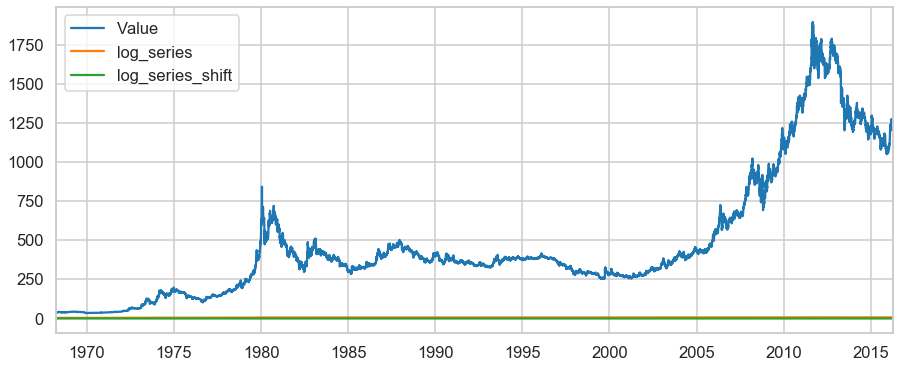

In [18]:
new_df.plot(figsize=(15, 6))
plt.show()

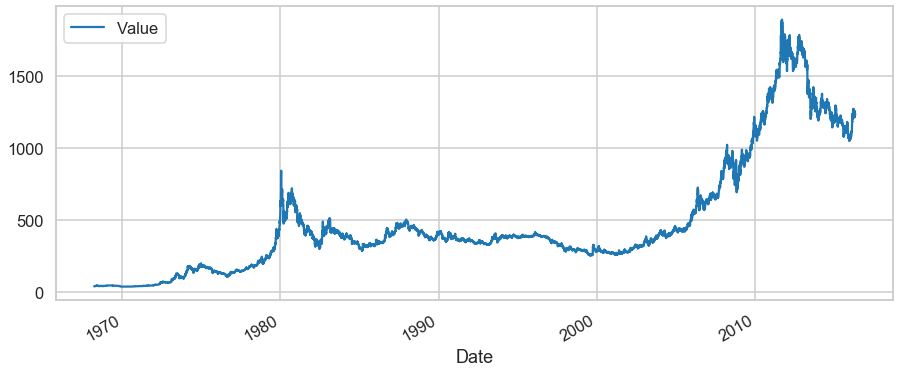

In [17]:
data.plot(figsize=(15, 6))

plt.show()

# 3/ Time series analysis for Forecasting, using ARIMA (Box-Jenkins)
- Auto Regressive Integrated Moving Average

## 3.1/ Check the time series data for Stationarity, using Augmented Dickey Fuller test
- If the test statistic of AD Fuller test is less than the critical value(s), we reject the null hypothesis of non-stationarity.

### 3.1.1/ Original Series

Test Statistic                    -0.364334
p-value                            0.915886
#Lags Used                        43.000000
Number of Observations Used    17506.000000
Critical Value (1%)               -3.430724
Critical Value (5%)               -2.861705
Critical Value (10%)              -2.566858
dtype: float64


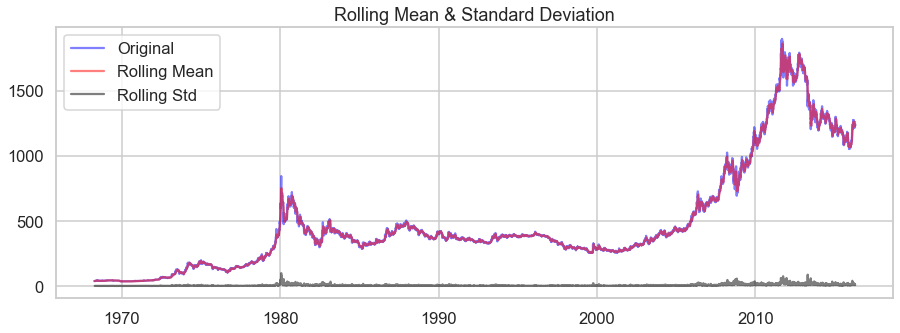

In [10]:
import sys
sys.path.insert(1,'E:\DUY\DS\deeplearning\PROJECTS\Custom_Tools')
import arima_tools as art

# Original Series
art.ad_fuller_test(new_df.Value)
art.plot_rolling_stats(new_df.Value)

- The test statistic of -0.36 is greater than either of critical values, hence we FAIL to reject the null hypothesis.
- Or it means that the series is NON-stationary.

### 3.1.2/ Log Series

Test Statistic                    -1.849748
p-value                            0.356057
#Lags Used                        29.000000
Number of Observations Used    17520.000000
Critical Value (1%)               -3.430723
Critical Value (5%)               -2.861705
Critical Value (10%)              -2.566858
dtype: float64


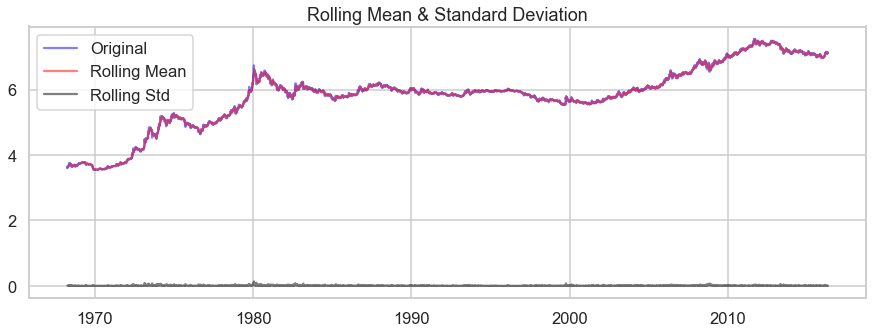

In [11]:
import numpy as np
log_series = np.log(new_df.Value)

art.ad_fuller_test(log_series)
art.plot_rolling_stats(log_series)

- The test statistic of -1.85 is greater than either of critical values, hence we also FAIL to reject the null hypothesis.
- Or it means that the series is NON-stationary even after log transformation.

## 3.2/ Stabilize the series, using Differencing method
- If the test statistic of AD Fuller test is less than the critical value(s), we reject the null hypothesis of non-stationarity.

Test Statistic                   -23.917175
p-value                            0.000000
#Lags Used                        28.000000
Number of Observations Used    17520.000000
Critical Value (1%)               -3.430723
Critical Value (5%)               -2.861705
Critical Value (10%)              -2.566858
dtype: float64


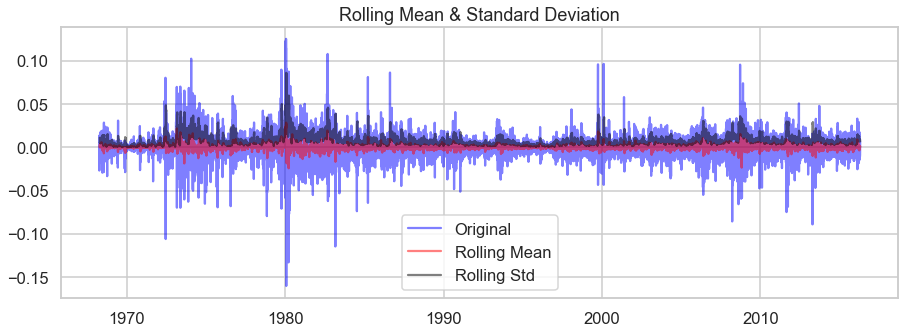

In [12]:
log_series_shift = log_series - log_series.shift()
log_series_shift = log_series_shift[~np.isnan(log_series_shift)]


art.ad_fuller_test(log_series_shift)
art.plot_rolling_stats(log_series_shift)

- The test statistic at -23.91 is lower than even 1% critical value, thus we reject the null hypothesis.
- It means that the series now is stationary

## 3.3/ Determine p,q parameters for ARIMA, by using plots of ACF and PACF
- ACF (Auto Correlation Function) and PACF (Partial Auto Correlation Function) plots helps us
narrow down the search space of determining the p and q values with a few caveats.
    - p is the order of Autoregression (using PACF plot)
    - q is the order of Moving average (using ACF plot)
    - d is the order of differencing

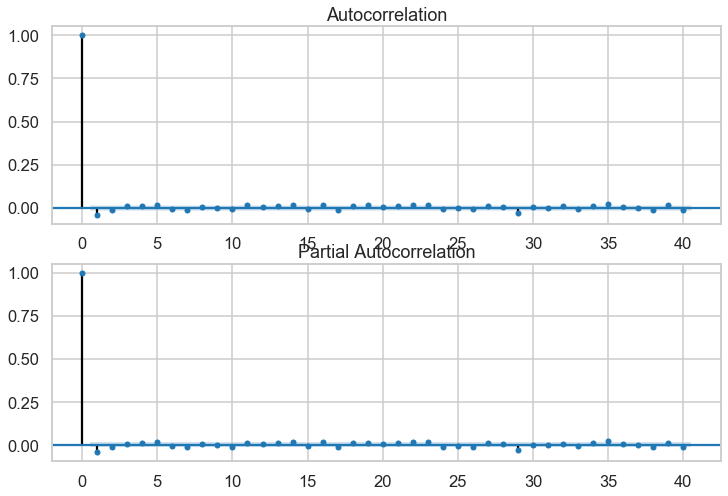

In [13]:
art.plot_acf_pacf(log_series_shift)


- The output plots show a sudden drop at lag 1 for both ACF and PACF, thus pointing toward
possible values of q and p to be 1 each, respectively.

## 3.3/ using ARIMA

In [14]:
new_df["log_series"] = log_series
new_df["log_series_shift"] = log_series_shift
new_df.head()

,Value,log_series,log_series_shift
1968-04-01,38.0,3.637586,NaN
1968-04-02,37.6,3.627004,-0.010582
1968-04-03,37.7,3.629660,0.002656
1968-04-04,36.7,3.602777,-0.026883
1968-04-05,37.2,3.616309,0.013532


********************
Iteration 1 of 5
TRAIN: [   0    1    2 ... 2922 2923 2924] TEST: [2925 2926 2927 ... 5847 5848 5849]
Train shape:(2925,), Test shape:(2925,)
ARIMA(0, 0, 0)- AIC:5358.675881541096
ARIMA(0, 0, 1)- AIC:1370.644173716044
ARIMA(0, 1, 0)- AIC:-17795.53995335306
ARIMA(0, 1, 1)- AIC:-17793.56497363464
ARIMA(1, 0, 0)- AIC:-17788.09838875447
ARIMA(1, 0, 1)- AIC:-17786.104195005828
ARIMA(1, 1, 0)- AIC:-17793.562143972755
ARIMA(1, 1, 1)- AIC:-17794.157105708953
Best Model params:(0, 1, 0) AIC:-17795.53995335306
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                 2924
Model:                 ARIMA(0, 1, 0)   Log Likelihood                8899.770
Method:                           css   S.D. of innovations              0.012
Date:                Fri, 05 Jun 2020   AIC                         -17795.540
Time:                        22:13:37   BIC                         -17783.579

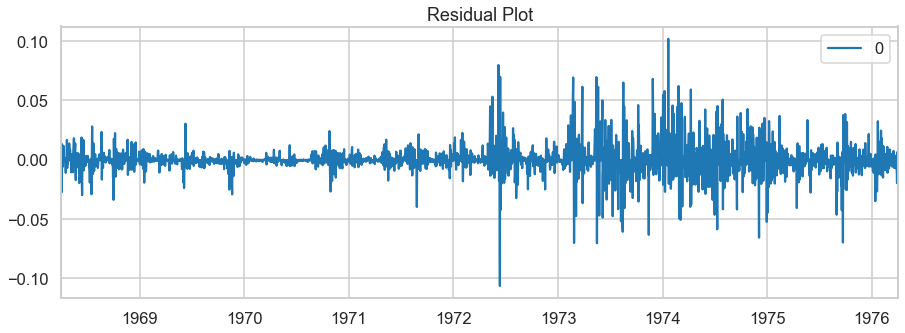

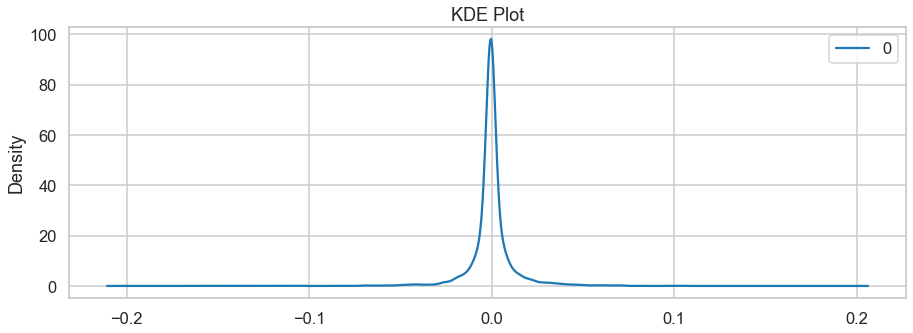

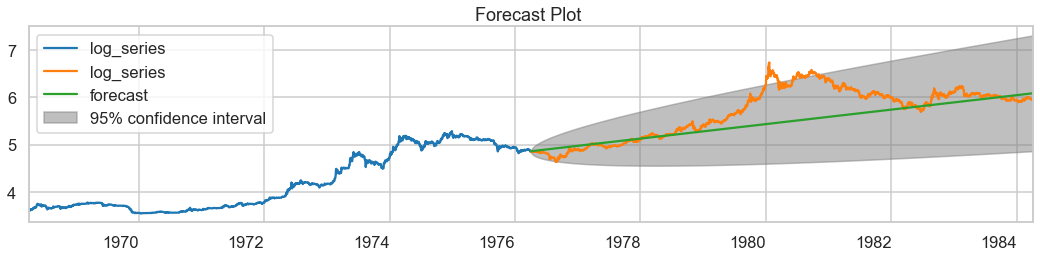

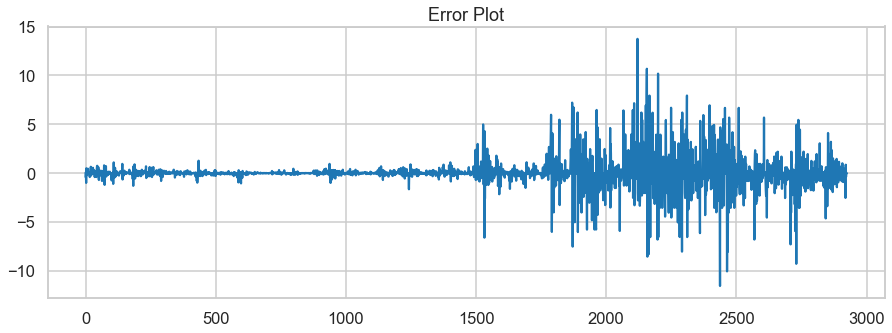

********************
Iteration 2 of 5
TRAIN: [   0    1    2 ... 5847 5848 5849] TEST: [5850 5851 5852 ... 8772 8773 8774]
Train shape:(5850,), Test shape:(2925,)
ARIMA(0, 0, 0)- AIC:15792.660349788819
ARIMA(0, 0, 1)- AIC:7814.097096459995
ARIMA(0, 1, 0)- AIC:-33512.28307448926
ARIMA(0, 1, 1)- AIC:-33516.96483489989
ARIMA(1, 0, 0)- AIC:-33502.69898070296
ARIMA(1, 0, 1)- AIC:-33507.0076842171
ARIMA(1, 1, 0)- AIC:-33516.56690977645
ARIMA(1, 1, 1)- AIC:-33517.2871382611
Best Model params:(1, 1, 1) AIC:-33517.2871382611
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                 5849
Model:                 ARIMA(1, 1, 1)   Log Likelihood               16762.644
Method:                       css-mle   S.D. of innovations              0.014
Date:                Fri, 05 Jun 2020   AIC                         -33517.287
Time:                        22:13:40   BIC                         -33490.591
Samp

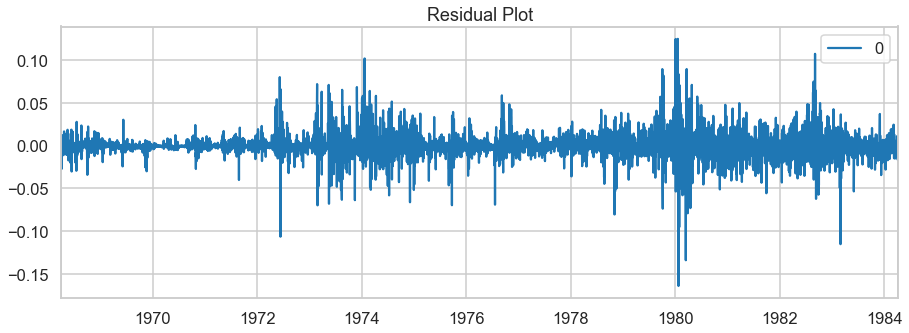

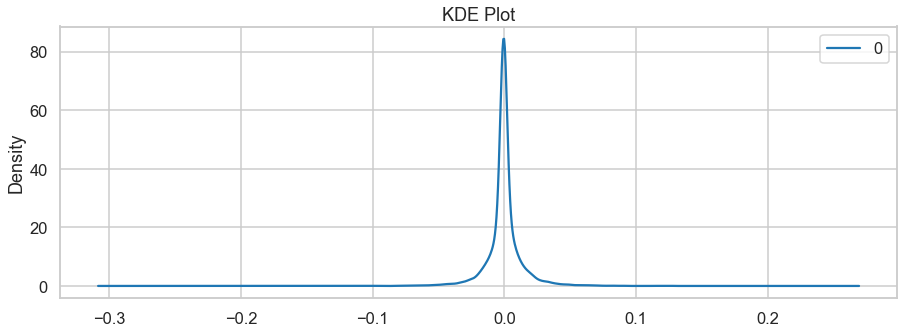

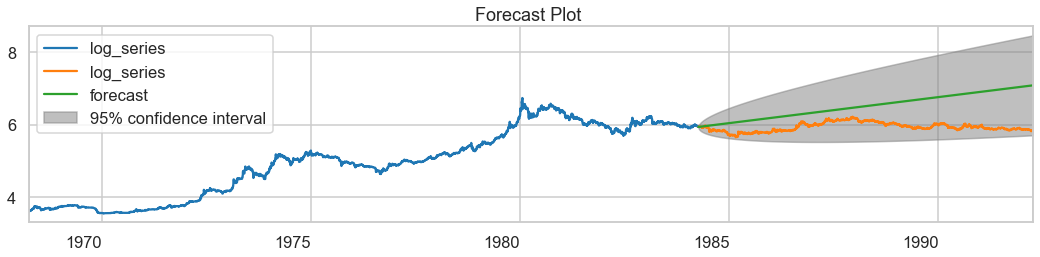

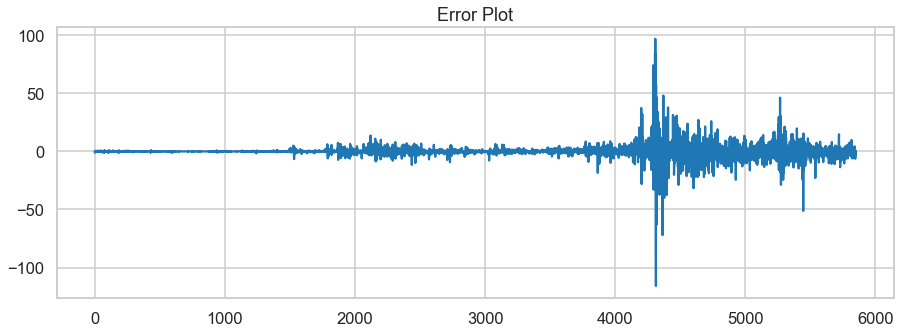

********************
Iteration 3 of 5
TRAIN: [   0    1    2 ... 8772 8773 8774] TEST: [ 8775  8776  8777 ... 11697 11698 11699]
Train shape:(8775,), Test shape:(2925,)
ARIMA(0, 0, 0)- AIC:22924.70092833443
ARIMA(0, 0, 1)- AIC:10939.92125625153
ARIMA(0, 1, 0)- AIC:-52348.468958811376
ARIMA(0, 1, 1)- AIC:-52365.88642216778
ARIMA(1, 0, 0)- AIC:-52340.13570759332
ARIMA(1, 0, 1)- AIC:-52357.13694276815
ARIMA(1, 1, 0)- AIC:-52364.9954035126
ARIMA(1, 1, 1)- AIC:-52366.21248650648
Best Model params:(1, 1, 1) AIC:-52366.21248650648
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                 8774
Model:                 ARIMA(1, 1, 1)   Log Likelihood               26187.106
Method:                       css-mle   S.D. of innovations              0.012
Date:                Fri, 05 Jun 2020   AIC                         -52366.212
Time:                        22:13:45   BIC                         -52337.

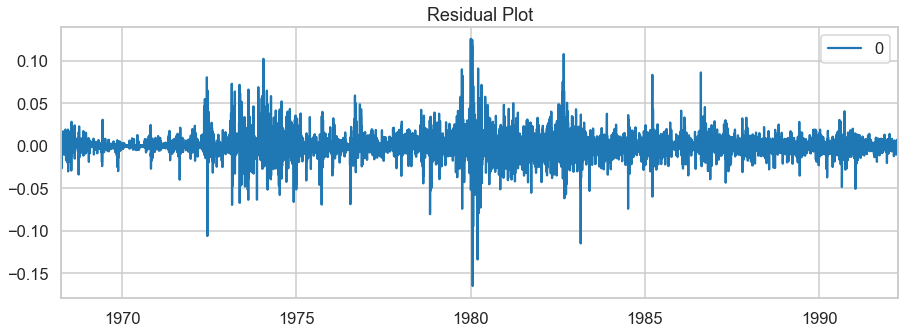

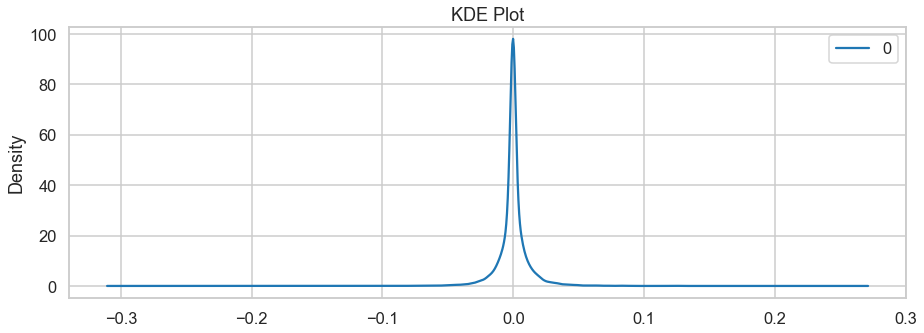

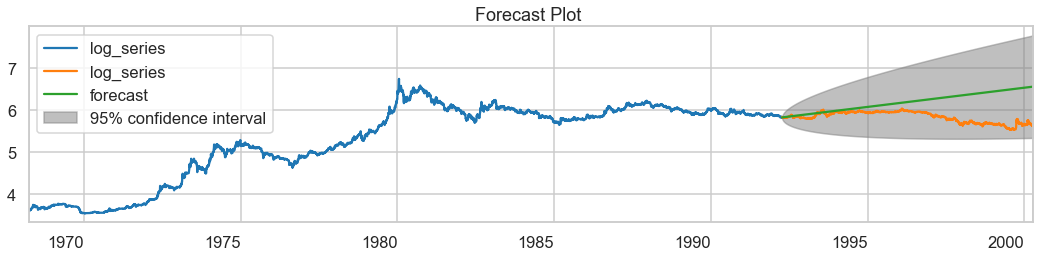

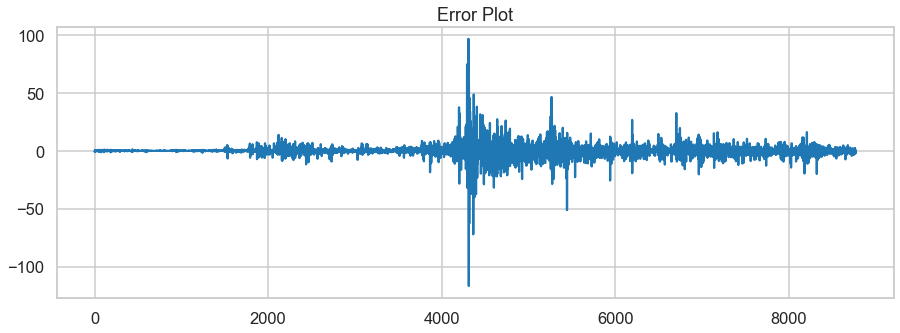

********************
Iteration 4 of 5
TRAIN: [    0     1     2 ... 11697 11698 11699] TEST: [11700 11701 11702 ... 14622 14623 14624]
Train shape:(11700,), Test shape:(2925,)
ARIMA(0, 0, 0)- AIC:28323.593243498868
ARIMA(0, 0, 1)- AIC:12343.352798126507
ARIMA(0, 1, 0)- AIC:-72092.36827299207
ARIMA(0, 1, 1)- AIC:-72119.82137921163
ARIMA(1, 0, 0)- AIC:-72085.08760872533
ARIMA(1, 0, 1)- AIC:-72112.1889308932
ARIMA(1, 1, 0)- AIC:-72118.75588542139
ARIMA(1, 1, 1)- AIC:-72119.86496021686
Best Model params:(1, 1, 1) AIC:-72119.86496021686
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                11699
Model:                 ARIMA(1, 1, 1)   Log Likelihood               36063.932
Method:                       css-mle   S.D. of innovations              0.011
Date:                Fri, 05 Jun 2020   AIC                         -72119.865
Time:                        22:13:52   BIC                        

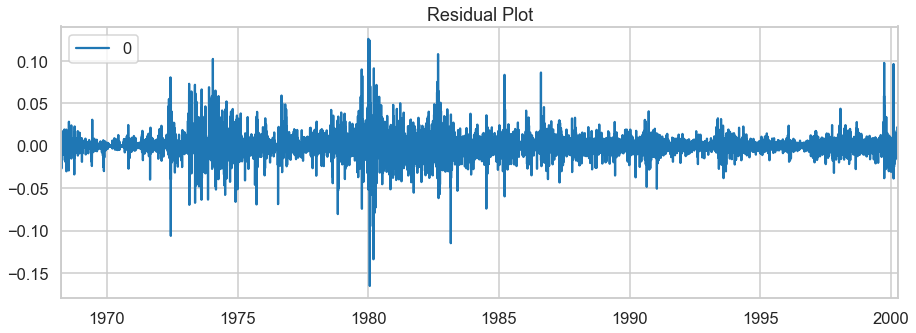

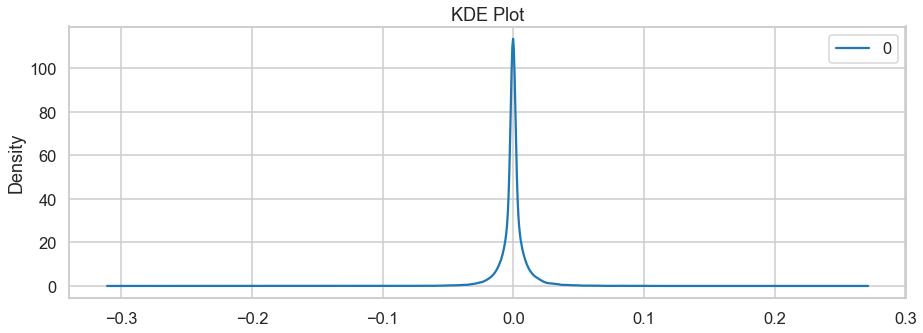

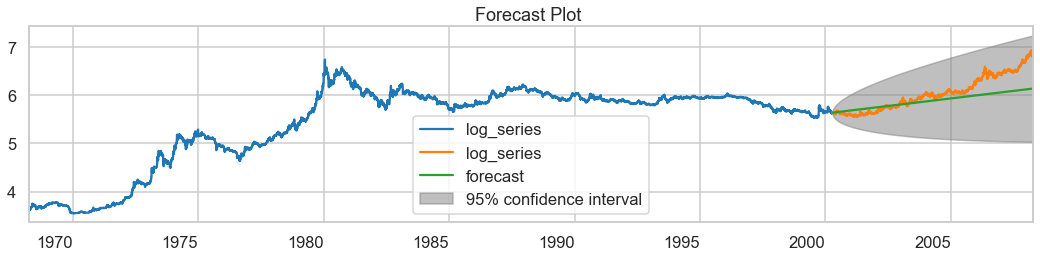

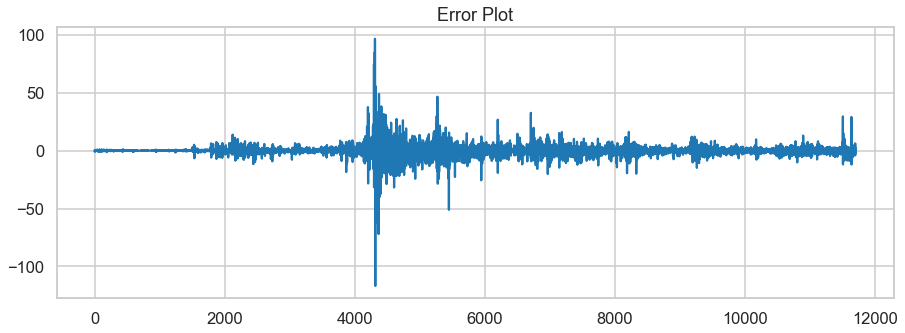

********************
Iteration 5 of 5
TRAIN: [    0     1     2 ... 14622 14623 14624] TEST: [14625 14626 14627 ... 17547 17548 17549]
Train shape:(14625,), Test shape:(2925,)
ARIMA(0, 0, 0)- AIC:34336.88986620506
ARIMA(0, 0, 1)- AIC:14355.652400375893
ARIMA(0, 1, 0)- AIC:-91312.75496091212
ARIMA(0, 1, 1)- AIC:-91348.77150649152
ARIMA(1, 0, 0)- AIC:-91301.1318471588
ARIMA(1, 0, 1)- AIC:-91336.41118478222
ARIMA(1, 1, 0)- AIC:-91347.65810577202
ARIMA(1, 1, 1)- AIC:-91348.29945380634
Best Model params:(0, 1, 1) AIC:-91348.77150649152
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                14624
Model:                 ARIMA(0, 1, 1)   Log Likelihood               45677.386
Method:                       css-mle   S.D. of innovations              0.011
Date:                Fri, 05 Jun 2020   AIC                         -91348.772
Time:                        22:14:01   BIC                         

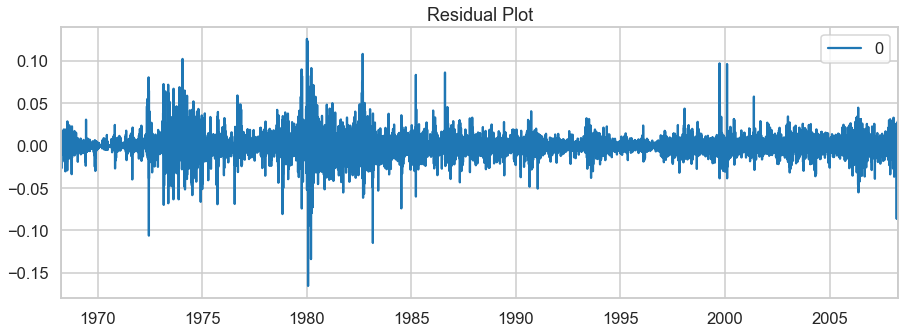

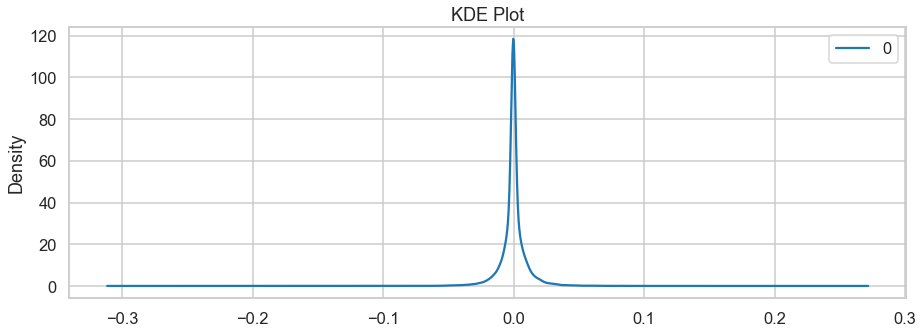

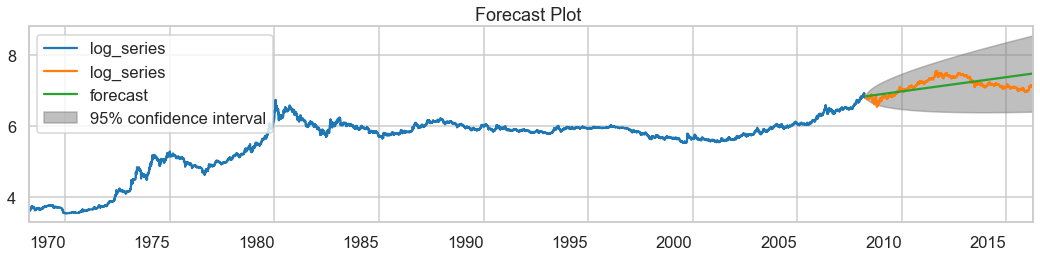

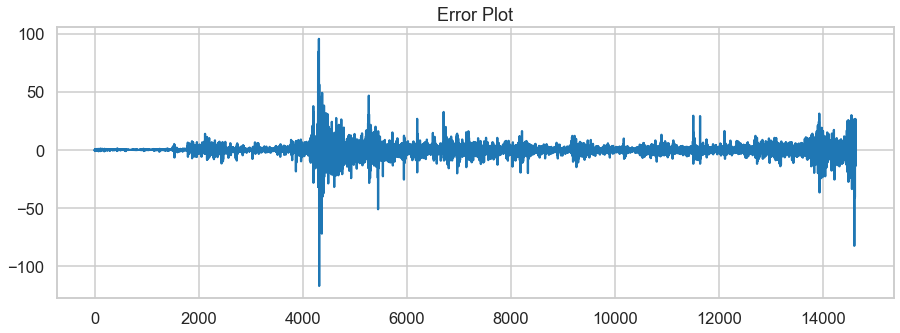

In [15]:
results_dict = art.arima_gridsearch_cv(new_df.log_series,cv_splits=5)



In [19]:
[f"col{i}" for i in range(5)]



['col0', 'col1', 'col2', 'col3', 'col4']

In [ ]:
r1111b46351
